In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
Home = str(Path.home())

import numpy as np
import pandas as pd

import re

import sys
path = f'{Home}/repos/EPObjects/'
sys.path.insert(0, path)

from Probabilistic.Parameter import ProbabilisticParameters
from Probabilistic.EnergyPredictions import EnergyPrediction, ProbabilisticEnergyPrediction

from Helper.MLHelper import GetGenerator, GetRegressor, GetScalingLayer, Rescaling
from Helper.RunPeriodHelper import GetRunPeriodsFromFile

In [2]:
ColorsSolid = ['#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#ff7f0e',]
NumColors = len(ColorsSolid)

def RGBToHex(c):
    c = c.astype(np.int16)
    return '#%02x%02x%02x' %(c[0], c[1], c[2])

def HexToRGB(h):
    return np.array([int(h[i:i+2], base=16) for i in (1, 3, 5)], dtype=np.int16)

def GetWeighedColor(col1, col2='#ffffff', w=0.5):
    c1 = HexToRGB(col1)
    c2 = HexToRGB(col2)
    return RGBToHex((c1 * (1-w)) + (w * c2))

class ColorScale:
    def __init__(self, c1, c2, mi, ma):
        self.Color1 = c1
        self.Color2 = c2
        self.Min = mi
        self.Max = ma
        self.Range = self.Max - self.Min
        
    def Color(self, value):
        if isinstance(value, np.ndarray):     
            vs = []
            for v in value:
                vs.append(GetWeighedColor(self.Color1, self.Color2, (v-self.Min)/self.Range))
            return vs
        return GetWeighedColor(self.Color1, self.Color2, (value-self.Min)/self.Range)

In [3]:
TestPath = f'{Home}/repos/EPObjects/Tausendpfund/'
Number = 1
NumSamples = 100
pps = ProbabilisticParameters.ReadCsv(f'{TestPath}/Parameters.csv')
_, Targets = GetRunPeriodsFromFile(f'{TestPath}/Consumption.csv')

names = [
    "u-value: Walls\n(W/m\u00b2K)",
    "u-value: Floor\n(W/m\u00b2K)",
    "u-value: Roof\n(W/m\u00b2K)",
    "u-value: Window\n(W/m\u00b2K)",
    "g-value\n(-)",
    "Permeability\n(m\u00b3/m\u00b2-h)",
    "Occupancy\n(persons/sq. m.)",
    "Heating\nsetpoint (\N{DEGREE SIGN}C)",
    "Internal mass\n(kJ/m\u00b2)",
    "Light heat\ngain (W/m\u00b2)",
    "Equipment heat\ngain (W/m\u00b2)",
    "Coefficient of\nperformance (-)",
]


In [4]:
pEnergies = []
for i in range(NumSamples):
    data = pd.read_csv(f'{TestPath}/IDFFiles-{Number}/{i}.csv', index_col=0)
    data.index = range(len(data))
    pEnergies += [EnergyPrediction(None, data)]

SimulationData = ProbabilisticEnergyPrediction(None, pEnergies)
Results = SimulationData.Values['Total']

In [5]:
g = GetGenerator(None, 100, list(str(x.Parameter) for x in pps), f'{TestPath}/MLModel-{Number}/Generator', f'{path}/MLModel-{Number}/Regressor.h5', None, None, training=False)
Combinations = g.Predict(1, numModels=NumSamples, mean=False)

r = GetRegressor(None, list(str(x.Parameter) for x in pps), SimulationData.Values['Total'].columns, f'{TestPath}/MLModel-{Number}/Regressor', None, None, training=False)
_ = r.Predict(Combinations)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-04-05 17:19:03.986414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 17:19:03.986809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-05 17:19:08.440860: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 17:19:08.499950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


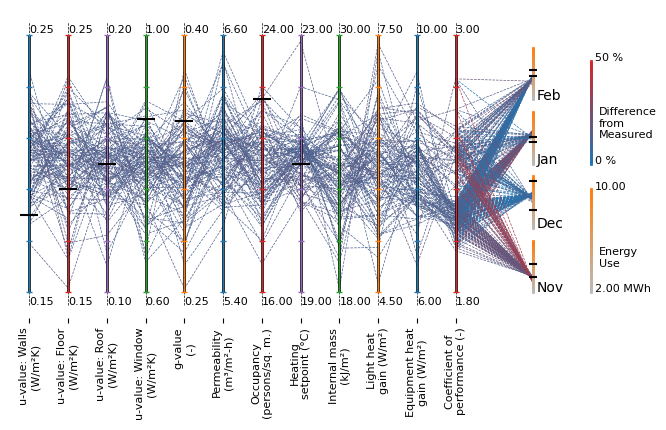

In [7]:
mi = np.array([pp.Min for pp in pps])
ra = np.array([pp.Max-pp.Min for pp in pps])
ScalingX = Rescaling(1./ra, offset = -mi/ra)
SampleScaled = ScalingX([0.18, 0.19, 0.15, 0.87, 0.35, float('nan'), 22.0, 21.0, float('nan'), float('nan'), float('nan'), float('nan')]).numpy()

NumParameters = len(mi)
ResultsStartAt = NumParameters + 1

fig, ax = plt.subplots(figsize=(NumParameters/2 + 2, 4), nrows = 1, ncols = 1)

for i, pp in enumerate(pps):
    ax.plot([i, i], [-.05, 1.05], lw=0.5, ls='--', color='k', zorder=1)
    ax.bar([i, i], [0, 1], width=0.05, ec='k', lw=0.5, zorder=2, color=ColorsSolid[i%NumColors])
    plt.plot(i * np.ones((6)), np.linspace(0, 1, 6), marker='_', markersize=5, color=ColorsSolid[i%NumColors], lw=0.1)
    
    plt.text(i, -0.05, f'{pp.Min:.02f}', size=8)
    plt.text(i, 1.01, f'{pp.Max:.02f}', size=8)
    
    try: plt.scatter(i, SampleScaled[i], 150, marker='_', color='k', zorder=100)
    except: pass

ma, mi = math.ceil(Results.values.max()) + 1, math.floor(Results.values.min())
ra = ma-mi
ScalingY = Rescaling(1./ra, offset = -mi/ra)

ErrorScale = ColorScale('#1f77b4', '#d62728', 0, 0.5)

previous = None
for i, comb in Combinations.iterrows():
    x = ScalingX(comb[:NumParameters]).numpy()
    for p, x1 in enumerate(x):
        if previous is not None:
            error = np.mean(np.abs((comb[NumParameters:].values - Targets.values.T.mean(axis=0))/Targets.values.T.mean(axis=0)))
            plt.plot([previous[0], p], [previous[1], x1], lw=0.5, ls='--', color=ErrorScale.Color(error), zorder=-1)
        previous = [p, x1]
    
    res = ScalingY(comb[NumParameters:]).numpy()*0.2
    for j, t in enumerate(res):
        error = np.abs((comb[NumParameters:].values[j] - Targets.values.T.mean(axis=0)[j])/Targets.values.T.mean(axis=0)[j])
        plt.plot([previous[0], ResultsStartAt], [previous[1], j*0.25 + t], lw=0.5, ls='--', color=ErrorScale.Color(error), zorder=-1)
        
    previous = None

ConsumptionScale = ColorScale('#bbbbbb', '#ff7f0e', 0, 1.0)
breaks = 50
for i, t in enumerate(Targets.values.T[0]):
    plt.text(ResultsStartAt+0.1, i*.25, Targets.index[i][:3], horizontalalignment='left')
    for j in range(breaks):
        ax.plot([ResultsStartAt, ResultsStartAt], [i*0.25 + j*0.2/breaks, i*0.25 + (j+1) * 0.2/breaks], lw=2, ls='-', color=ConsumptionScale.Color(j/breaks), zorder=1)
        if i==0:
            ax.plot([ResultsStartAt+1.5, ResultsStartAt+1.5], [i*0.25 + j*0.4/breaks, i*0.25 + (j+1) * 0.4/breaks], lw=2, ls='-', color=ConsumptionScale.Color(j/breaks), zorder=1)
    
ax.text(ResultsStartAt+1.6, 0, f'{mi:.02f} MWh', size=8)
ax.text(ResultsStartAt+1.7, 0.1, f'Energy\nUse', size=8)
ax.text(ResultsStartAt+1.6, 0.4, f'{ma:.02f}', size=8)

for j in range(breaks):
    ax.plot([ResultsStartAt+1.5, ResultsStartAt+1.5], [0.5 + j*0.4/breaks, 0.5 + (j+1) * 0.4/breaks], lw=2, ls='-', color=ErrorScale.Color(j*0.5/breaks), zorder=1)

ax.text(ResultsStartAt+1.6, 0.5, f'0 %', size=8)
ax.text(ResultsStartAt+1.7, 0.6, f'Difference\nfrom\nMeasured', size=8)
ax.text(ResultsStartAt+1.6, 0.9, f'50 %', size=8)
        
for t in Targets.values.T:
    res = ScalingY(t).numpy() * 0.2
    for i, t in enumerate(res):
        ax.scatter([ResultsStartAt], [i*0.25 + t], marker='_', color='k')
        

# plt.axis('off')

xticks = tuple(x for x in pps)
ax.set_xticks(range(len(xticks)), labels=names, size=8, rotation=90, horizontalalignment='center', verticalalignment='top')
ax.set_yticks([])
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-.5, ResultsStartAt+2.5])

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.savefig('test.pdf', bbox_inches='tight')

In [99]:
vals = Targets.mean(axis=1)
for i, m in enumerate(vals):
    print (np.mean(np.abs(Combinations[f'Predicted_{i}'].values - vals.iloc[i])/vals.iloc[i]))

0.23209639
0.048956413
0.17501527
0.09275279


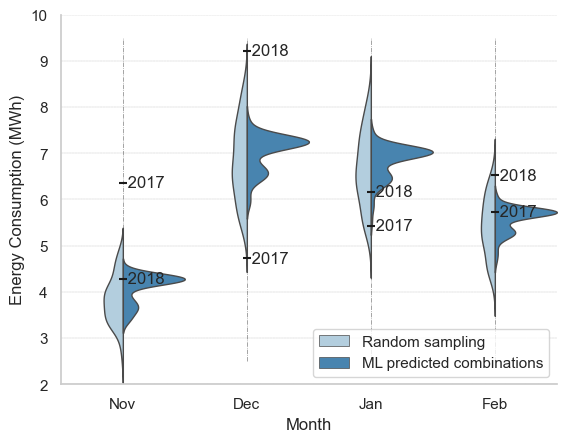

In [23]:
#half violin plots using seaborn graph
#upper values: parameter estimation (in results: simulationdata.values)
#lower values: combinations, last columns
#y1, y2 from Targets (measured values)
import seaborn as sns
sns.set_theme(style="whitegrid")

data = pd.DataFrame()
for x, month in enumerate(Results):
  plt.vlines(x, 2.5, 9.5, lw=0.5, color="grey", linestyle = '-.', zorder=-1) 
  
  d1 = pd.DataFrame()
  d1['Energy'] = Results[month]
  d1['Approach'] = 'Random sampling'
  d1['Month'] = month

  d2= pd.DataFrame()
  d2['Energy'] = Combinations[f'Predicted_{x}']
  d2['Approach'] = 'ML predicted combinations'
  d2['Month'] = month

  data = pd.concat((data, d1, d2))

ax=sns.violinplot(data=data, width=1, x="Month", y="Energy", hue="Approach", split=True, inner=None, linewidth=1, palette="Blues")

for i, value in Targets.iterrows():
    plt.scatter([i, i], value, marker='_', color='k')
    for x, z in enumerate(['2017', '2018']):
        plt.text(i, value[x], f' {z}', verticalalignment='center')

plt.xticks(range(4), [x[:3] for x in Targets.index])

plt.ylabel('Energy Consumption (MWh)')
plt.xlim(-0.5, 3.5)
plt.ylim(2, 10)
plt.grid(axis='y', color='k', linestyle='--', linewidth=0.1)

ax.spines[['right', 'top',]].set_visible(False)
ax.legend(loc = "lower right")
plt.savefig('violin.pdf', bbox_inches='tight')
plt.show()


In [61]:
from scipy.stats import norm
from math import sqrt
from scipy.stats import t

import numpy as np
from numpy.random import seed
from numpy.random import rand
from numpy.random import randint
from numpy import mean
from numpy import median, mean

from numpy import percentile

def ConfidenceIntervalWithoutBS(y):
    alpha = 5.0
    lower_p = alpha / 2.0
    lower = percentile(y, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = percentile(y, upper_p)
    print (f'{lower:0.02f}-{upper:0.02f}')
    return lower, upper

def ConfidenceInterval(y, n=50):
    seed(1)
    scores = list()
    dataset = y
    samples = len(dataset)
    for _ in range(n):
        indices = randint(0, samples, samples)
        sample = dataset[indices]
        # calculate and store statistic
        statistic = sqrt(mean(sample))
        scores.append(statistic)
    
    m = mean(scores)
    
    alpha = 5.0
    lower_p = alpha / 2.0
    lower = percentile(scores, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = percentile(scores, upper_p)

    print (f'{lower:0.02f}-{upper:0.02f}')
    return lower, upper

In [62]:
for x, month in enumerate(results):
  print (month)
  ConfidenceIntervalWithoutBS(Combinations[f'Predicted_{x}'])
  ConfidenceIntervalWithoutBS(results[month])

November
3.41-4.35
2.83-4.87
December
6.09-7.38
5.43-8.39
January
5.92-7.13
5.31-8.09
February
4.85-5.81
4.30-6.49


In [21]:
Results

,0,1,2,3
0,4.157861,6.848022,6.635537,5.402255
1,3.650858,8.215516,8.019173,6.429538
2,4.220682,6.549274,6.254132,5.114974
3,4.647589,7.445955,7.248915,5.856539
4,3.292043,6.460395,6.403566,5.301084
...,...,...,...,...
95,3.311332,6.257234,6.237089,5.092301
96,3.614332,6.622631,6.564237,5.439635
97,3.991448,6.759594,6.538760,5.291135
98,3.488026,8.274133,8.120259,6.684371
